In [13]:
cd /bali/freqtrade

/bali/freqtrade


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta
import talib.abstract as ta
import pandas_ta as pta
from technical import qtpylib


In [15]:
df = pd.read_json('/bali/freqtrade/user_data/data/binance/futures/ETH_USDT-1h-futures.json')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df['date'] = df.date.apply(lambda x: pd.to_datetime(x, unit='ms'))


In [16]:
df1 = pd.read_json('2022-10-05 07:48:23.436271.json')                      
df2 = pd.read_json('2022-10-05 10:33:39.353703.json')                      
df1['long_profit'] = (df1['profit_ratio'].multiply(100)).round(2)
df1['short_profit'] = (df2['profit_ratio'].multiply(100)).round(2)
# df = df1[df.long_profit.notna()]
# df[df.long_profit.notna()]
df = df1.copy()
# df = df[-10000:]
 
df.loc[(df.long_profit > 0) & (df.short_profit < 0), 'label'] = 'long'
df.loc[(df.long_profit < 0) & (df.short_profit > 0), 'label'] = 'short'
df.loc[(~df['label'].isin(['long', 'short'])) & (df.long_profit.notna()), 'label'] = 'hold'
""" prepare labels """
df.loc[(df['trade'] == 1)& (df['macd'] > df['macdsignal']), 'position'] = 'bottom' 
df.loc[(df['trade'] == 1)& (df['macd'] < df['macdsignal']), 'position'] = 'top'
df.loc[(df['trade'] == 1)& (df['macd'] > df['macdsignal']), 'position'] = 'long' 
df.loc[(df['trade'] == 1)& (df['macd'] < df['macdsignal']), 'position'] = 'short'

FileNotFoundError: File 2022-10-05 07:48:23.436271.json does not exist

In [55]:
df['rsi'] = ta.RSI(df)
df['adx'] = ta.ADX(df)
df['volume_pct'] = df['volume'].pct_change()
df['close_pct'] = df['close'].pct_change()
df['close_log'] = np.log(df['close'])
macd = ta.MACD(df)
df['macd'] = macd['macd']
df['macdsignal'] = macd['macdsignal']
df['macdhist'] = macd['macdhist']
df['ao'] = qtpylib.awesome_oscillator(df)
df['uo'] = ta.ULTOSC(df)


features_kmeans_dict_20bar = {'adx':[], 'rsi':[], 'macdhist':[],'ao':[],'uo':[],'close_pct':[],'volume_pct':[] }
features_kmeans_dict_10bar = {'adx':[], 'rsi':[], 'macdhist':[],'ao':[],'uo':[],'close_pct':[],'volume_pct':[]}
features_kmeans_dict_3bar = {'adx':[], 'rsi':[], 'macdhist':[],'ao':[],'uo':[],'close_pct':[],'volume_pct':[]}
features_kmeans_dict_1bar = {'adx':[], 'rsi':[], 'macdhist':[],'ao':[],'uo':[],'close_pct':[],'volume_pct':[], 'close':[], 'volume':[], 'open':[], 'high':[], 'low':[]}

features_kemeans_dict = {'bar_20':features_kmeans_dict_20bar, 'bar_10':features_kmeans_dict_10bar, 'bar_3':features_kmeans_dict_3bar}

for i in features_kmeans_dict_20bar:
    for j in range(20,0,-1):
        features_kmeans_dict_20bar[i].append(f'{i}_-{j}')
        df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
for i in features_kmeans_dict_10bar:
    for j in range(10,0,-1):
        features_kmeans_dict_10bar[i].append(f'{i}_-{j}')
        df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
for i in features_kmeans_dict_3bar:
    for j in range(3,0,-1):
        features_kmeans_dict_3bar[i].append(f'{i}_-{j}')
        df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
for i in features_kmeans_dict_1bar:
    for j in range(1,0,-1):
        features_kmeans_dict_1bar[i].append(f'{i}_-{j}')
        df[f'{i}_-{j}'] = df[f'{i}'].shift(j)


/tmp/ipykernel_55861/3272349391.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
/tmp/ipykernel_55861/3272349391.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
/tmp/ipykernel_55861/3272349391.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [59]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)
# numeric_df = df.copy()
numeric_df


,date,open,high,low,close,volume,rsi,adx,volume_pct,close_pct,...,volume_pct_-7,volume_pct_-6,volume_pct_-5,volume_pct_-4,volume_pct_-3,volume_pct_-2,volume_-1,open_-1,high_-1,low_-1
0,2019-11-27 07:00:00,4.983607,4.983607,4.983607,4.983607,-4.605170,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-11-27 08:00:00,4.828554,4.976803,4.828554,4.890349,-2.525729,NaN,NaN,1.945910,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.605170,4.983607,4.983607,4.983607
2,2019-11-27 09:00:00,4.890349,4.890349,4.890349,4.890349,-inf,NaN,NaN,NaN,-inf,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.525729,4.828554,4.976803,4.828554
3,2019-11-27 10:00:00,4.957235,4.973418,4.956531,4.960184,7.948989,NaN,NaN,inf,-2.626505,...,NaN,NaN,NaN,NaN,NaN,1.945910,-inf,4.890349,4.890349,4.890349
4,2019-11-27 11:00:00,4.960745,4.989888,4.957375,4.987571,9.113807,NaN,NaN,0.790882,-3.583940,...,NaN,NaN,NaN,NaN,1.945910,NaN,7.948989,4.957235,4.973418,4.956531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25438,2022-10-22 05:00:00,7.167586,7.167809,7.165493,7.166945,11.050885,3.961853,2.906427,-1.792782,NaN,...,NaN,NaN,-0.645104,-2.651801,-1.714569,NaN,10.896881,7.168780,7.170027,7.167238
25439,2022-10-22 06:00:00,7.166953,7.168826,7.166667,7.167971,10.703167,3.987952,2.878522,NaN,-6.881766,...,NaN,-0.645104,-2.651801,-1.714569,NaN,NaN,11.050885,7.167586,7.167809,7.165493
25440,2022-10-22 07:00:00,7.167979,7.170343,7.167979,7.169373,11.133591,4.022670,2.827438,-0.620064,-6.569135,...,-0.645104,-2.651801,-1.714569,NaN,NaN,-1.792782,10.703167,7.166953,7.168826,7.166667
25441,2022-10-22 08:00:00,7.169381,7.171657,7.169365,7.170081,11.387087,4.039935,2.755338,-1.242985,-7.252755,...,-2.651801,-1.714569,NaN,NaN,-1.792782,NaN,11.133591,7.167979,7.170343,7.167979


/tmp/ipykernel_55861/3392854626.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts.replace(np.inf, 0, inplace=True)
/tmp/ipykernel_55861/3392854626.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts.replace(-np.inf, 0, inplace=True)
/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = k

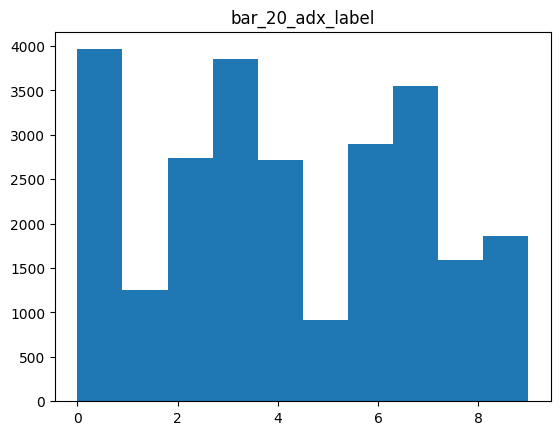

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


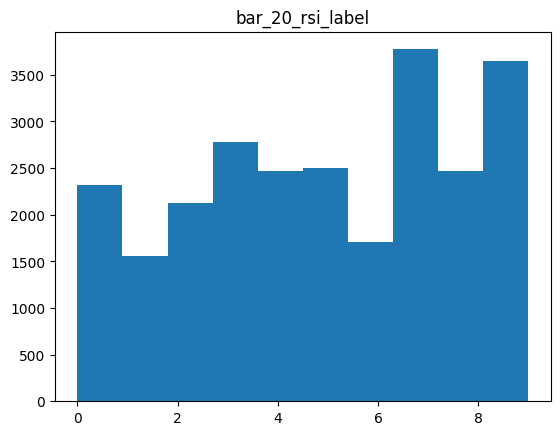

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


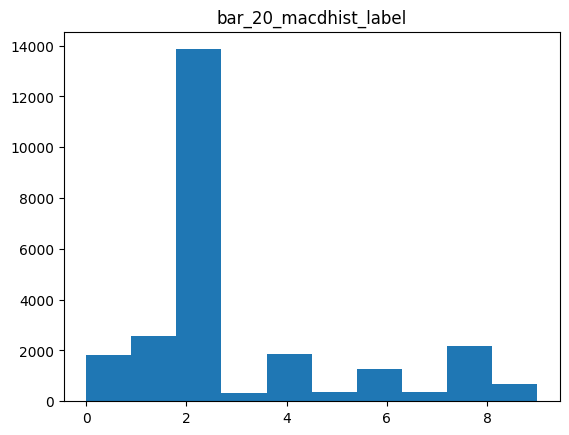

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


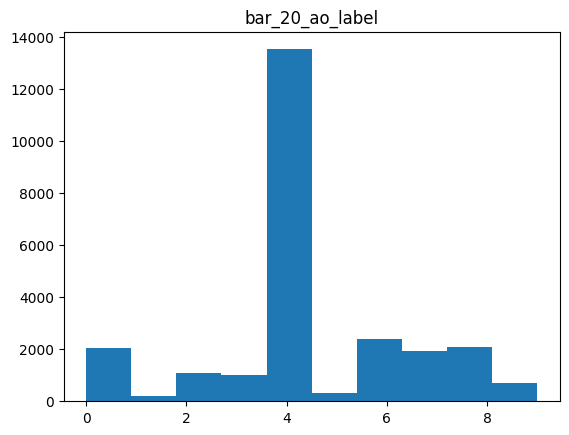

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


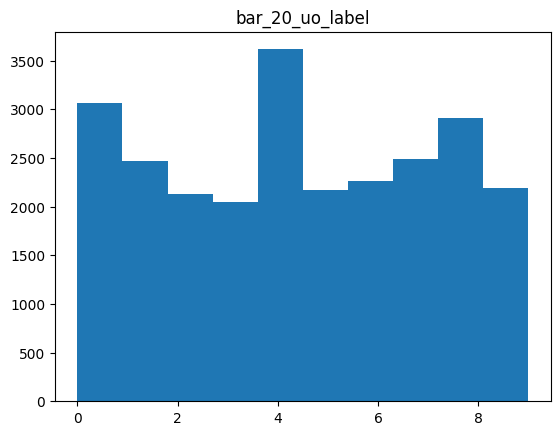

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


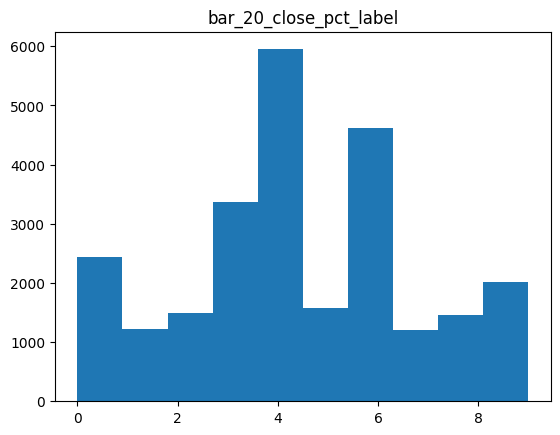

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


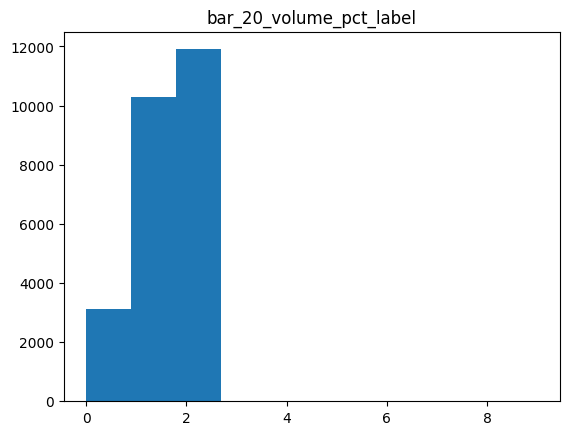

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


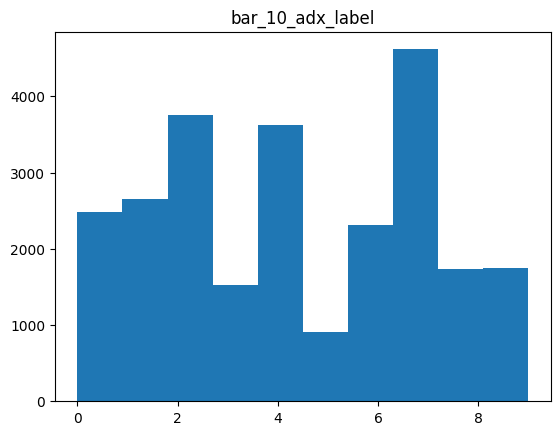

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


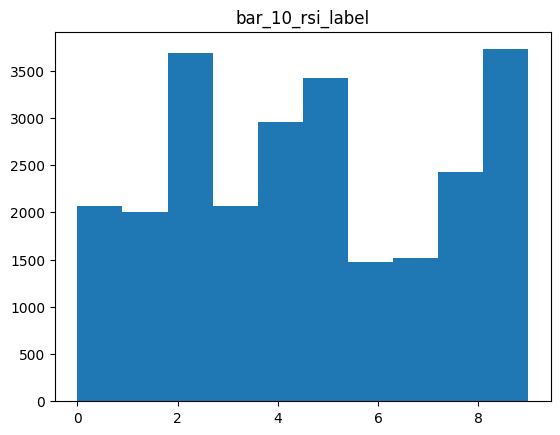

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


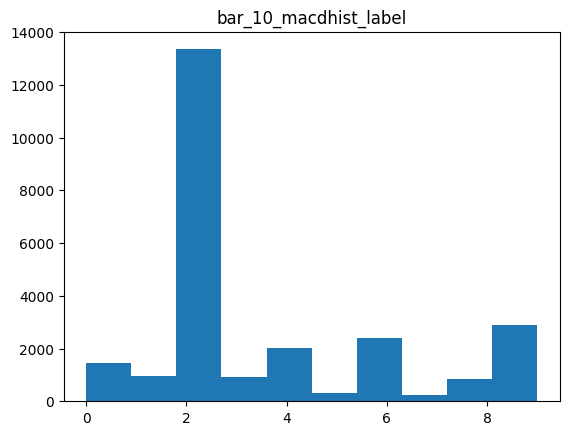

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


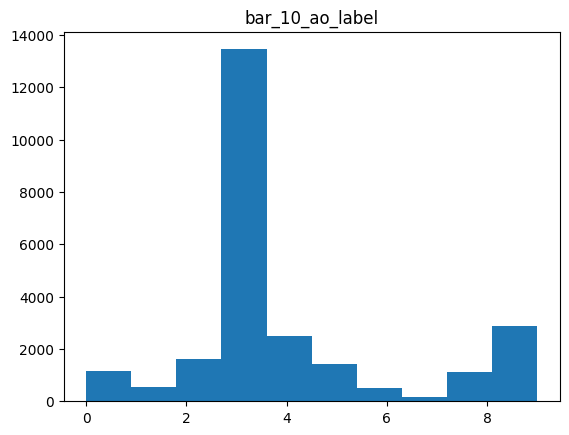

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


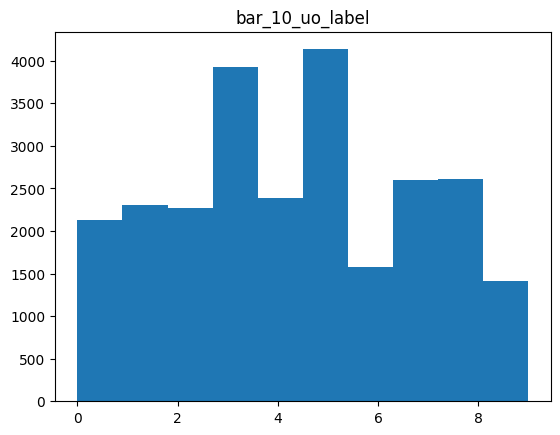

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


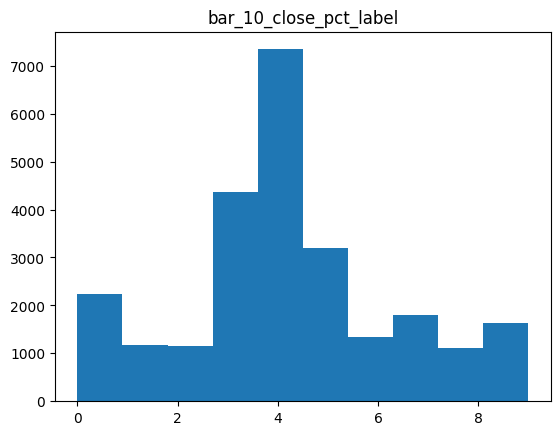

/tmp/ipykernel_55861/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


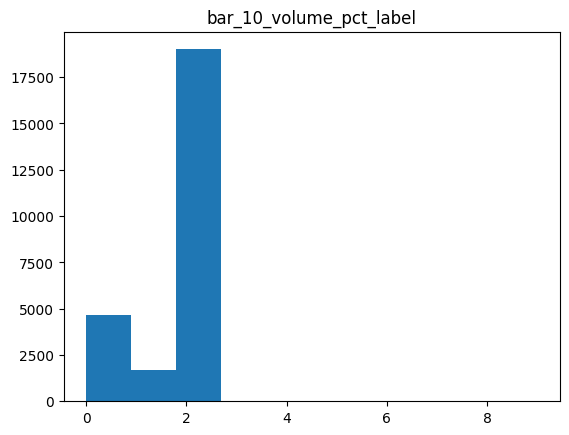

KeyboardInterrupt: 

In [58]:
""" test DTW code  """
from tslearn.clustering import TimeSeriesKMeans
import random
k_means_label = []
# df_kmeans = numeric_df.dropna()
df_kmeans = numeric_df.fillna(0)
df_kmeans_ts = df_kmeans[100:]
df_kmeans_ts.reset_index(drop=True, inplace=True)
df_kmeans_ts.replace(np.inf, 0, inplace=True)
df_kmeans_ts.replace(-np.inf, 0, inplace=True)
for i,j in features_kemeans_dict.items():
    for k,v in j.items():
        k_name = f'{i}_{k}'
        k_clusters = 10
        kmeans = TimeSeriesKMeans(n_clusters=k_clusters, random_state=42)
        y_pred = kmeans.fit_predict(df_kmeans_ts[v])
        # kmeans.labels_
        # kmeans.cluster_centers_.shape
        df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_
        k_means_label.append(f'{k_name}_label')
        plt.hist(kmeans.labels_, bins=10)
        plt.title(f'{k_name}_label')
        plt.show()

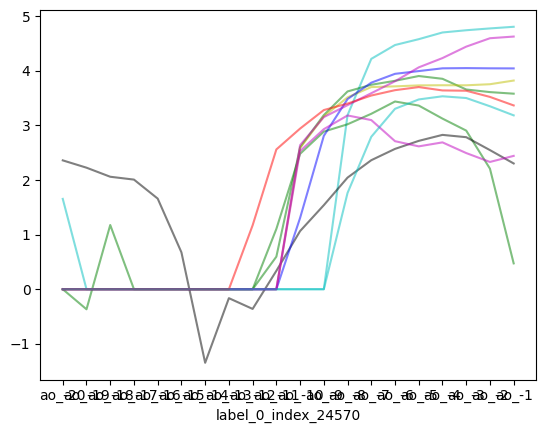

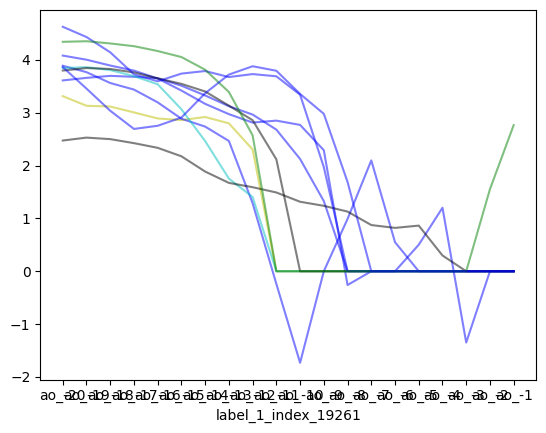

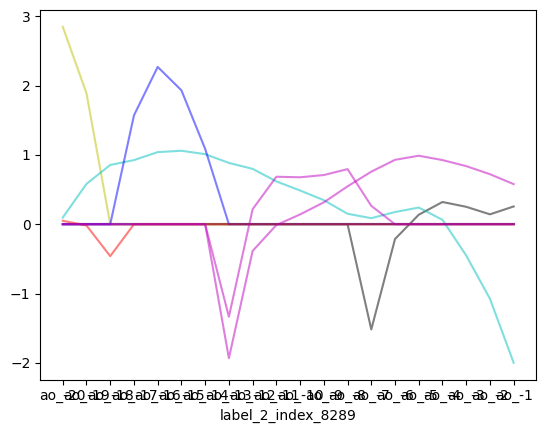

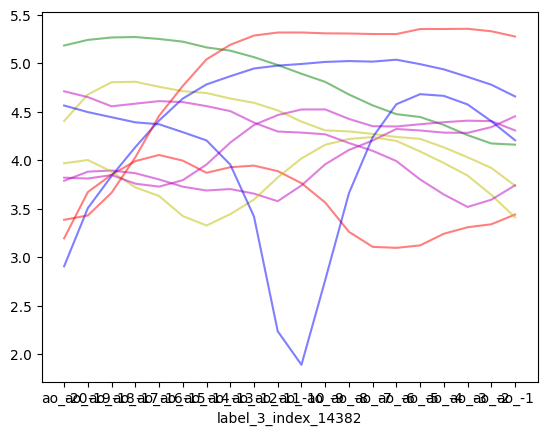

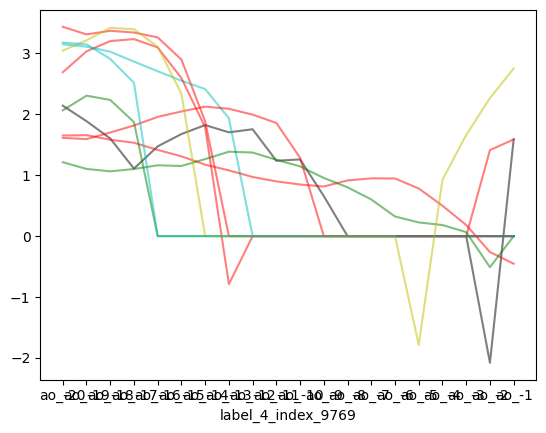

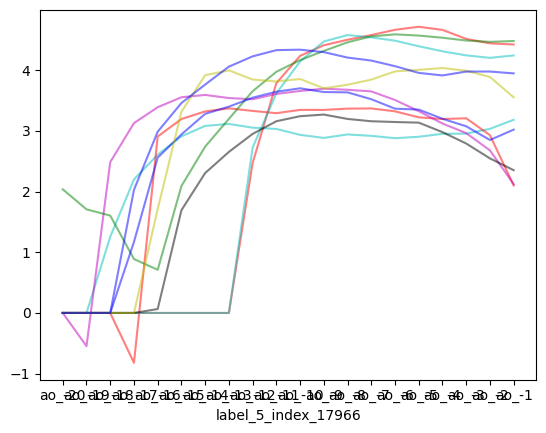

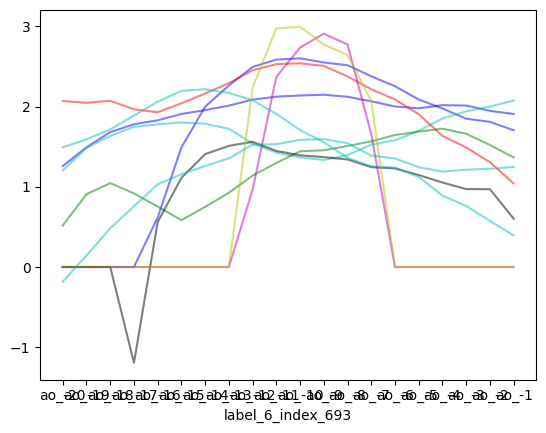

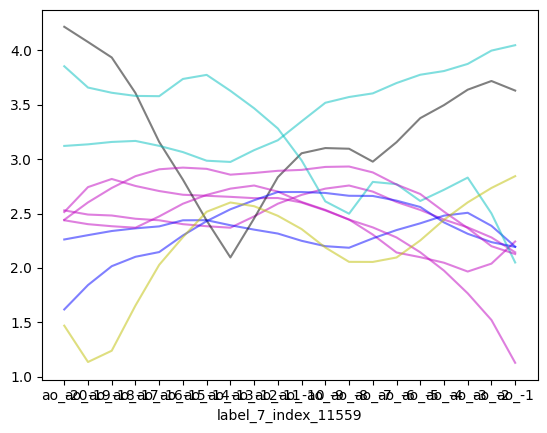

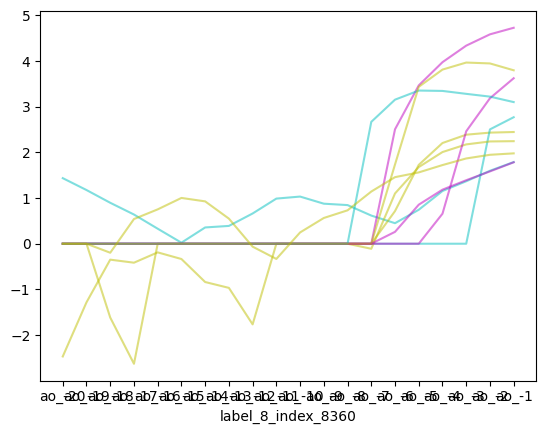

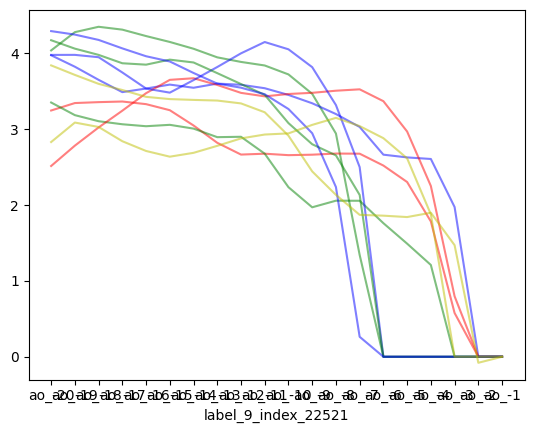

In [39]:
for times in range(0,10):
    for i in range(10):
            color = "bgrcmyk"
            
            # index_ = random.choice(df_kmeans_ts[df_kmeans_ts['bar_20_adx_label']==times].index)
            index_ = random.choice(df_kmeans_ts[df_kmeans_ts['bar_20_ao_label']==times].index)
            plt.xlabel(f'label_{times}_index_{index_}')
        #     plt.title = f'label_{times}_index_{index_}'
            # x = df_kmeans_ts.loc[index_,bar_3_ohlcv].columns
            # y =  df_kmeans_ts.loc[index_,bar_3_ohlcv].values.reshape(3,1)
            # plt.plot(x,y, color='blue', alpha=0.5, linewidth=1, linestyle='dashed', marker='o', markersize=4)
            plt.plot(df_kmeans_ts.loc[index_,features_kmeans_dict_20bar['ao']], color=random.choice(color), alpha=0.5)

            
    plt.show()        

<AxesSubplot: >

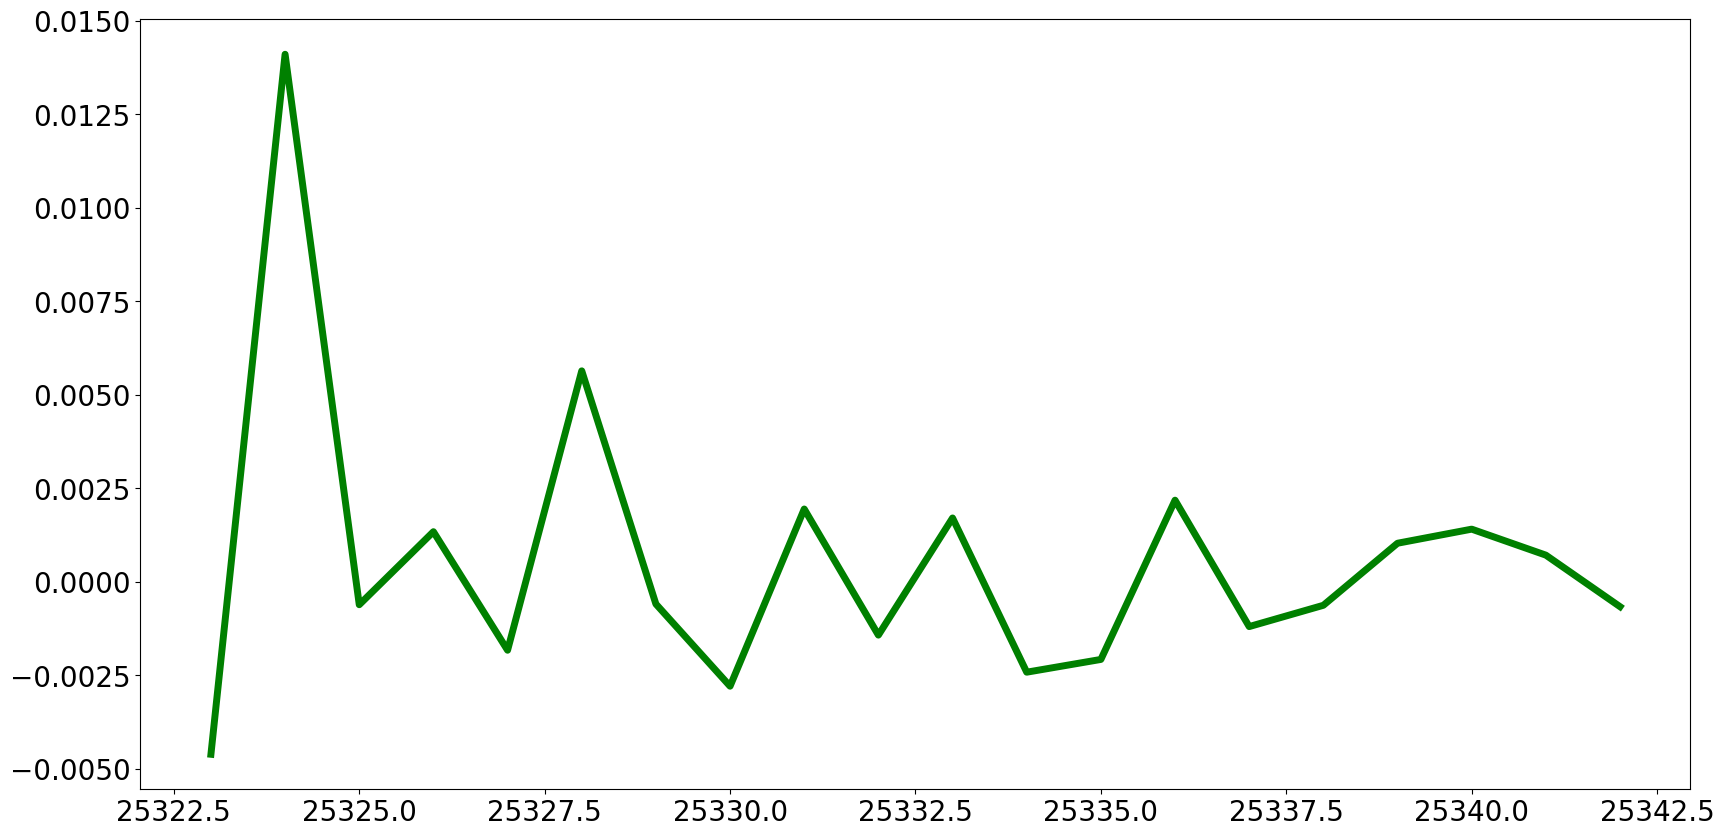

In [66]:
df_kmeans_ts['close_pct'].tail(20).plot( figsize=(20,10), linewidth=5, fontsize=20, color='green')

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

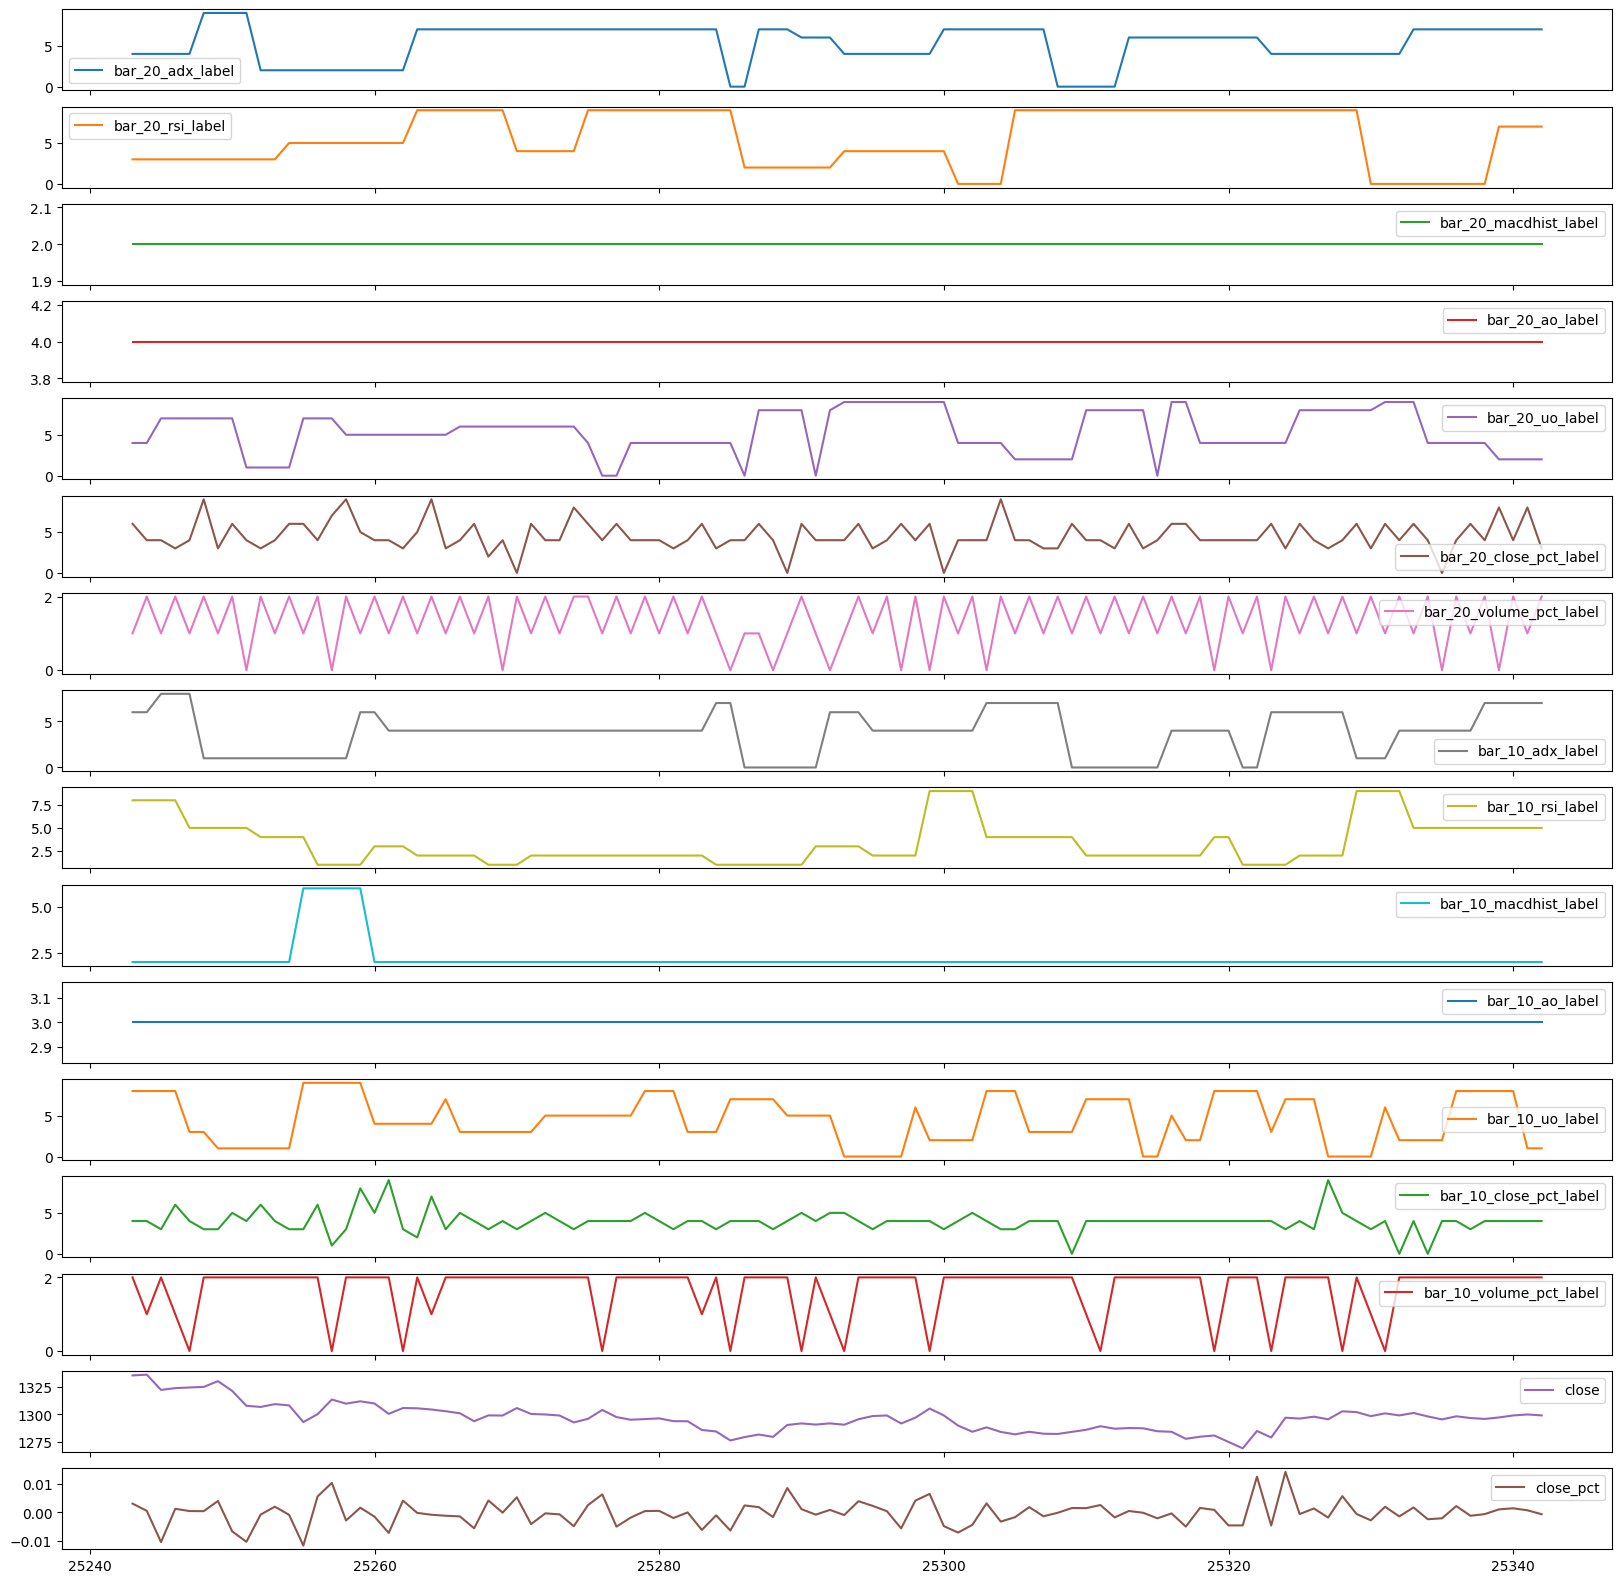

In [60]:
df_kmeans_ts[k_means_label+['close']+['close_pct']].tail(100).plot(subplots=True, figsize=(20, 20))

In [50]:
df_kmeans_ts['close_pct']

25243   -5.800272
25244   -7.553736
25245    0.000000
25246   -6.698540
25247   -7.715985
           ...   
25338    0.000000
25339   -6.881766
25340   -6.569135
25341   -7.252755
25342    0.000000
Name: close_pct, Length: 100, dtype: float64

In [42]:
k_means_label


['bar_20_adx_label',
 'bar_20_rsi_label',
 'bar_20_macdhist_label',
 'bar_20_ao_label',
 'bar_20_uo_label',
 'bar_20_close_pct_label',
 'bar_20_volume_pct_label',
 'bar_10_adx_label',
 'bar_10_rsi_label',
 'bar_10_macdhist_label',
 'bar_10_ao_label',
 'bar_10_uo_label',
 'bar_10_close_pct_label',
 'bar_10_volume_pct_label',
 'bar_3_adx_label',
 'bar_3_rsi_label',
 'bar_3_macdhist_label',
 'bar_3_ao_label',
 'bar_3_uo_label',
 'bar_3_close_pct_label',
 'bar_3_volume_pct_label']

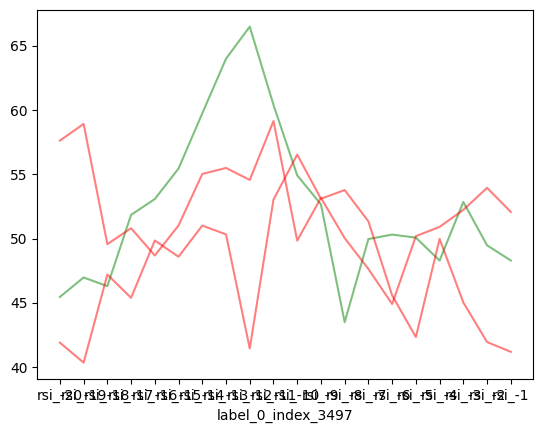

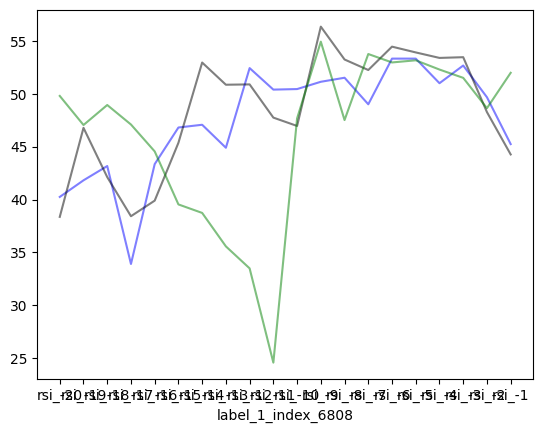

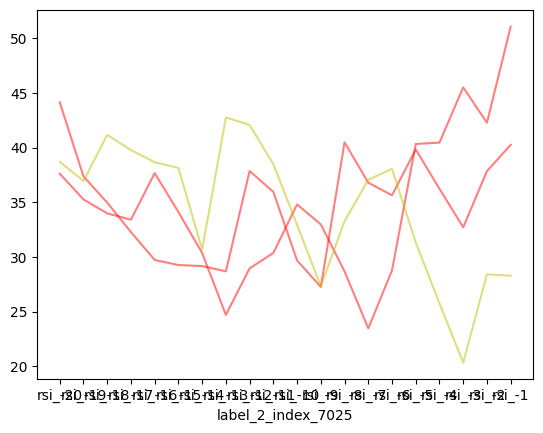

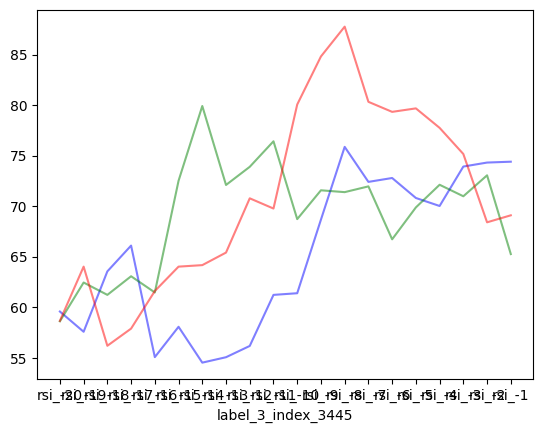

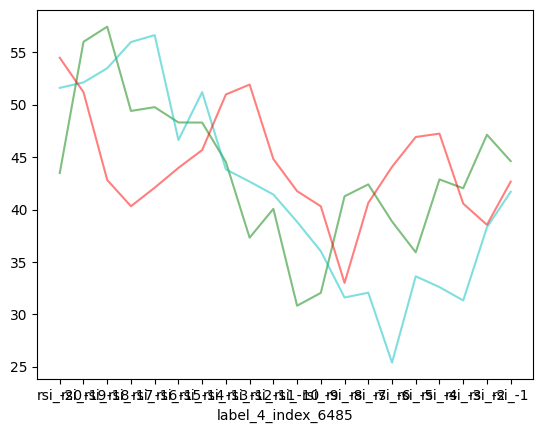

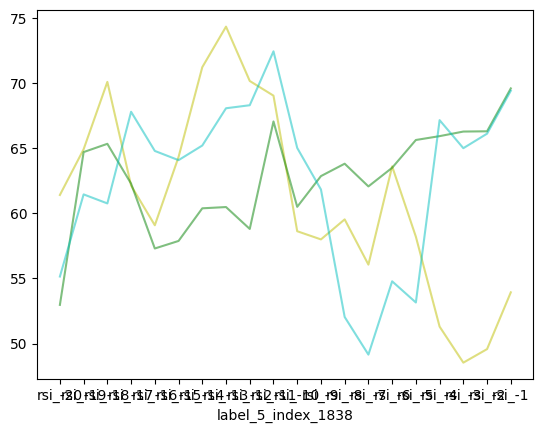

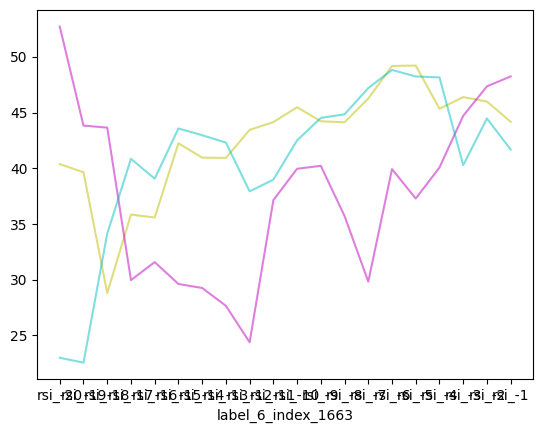

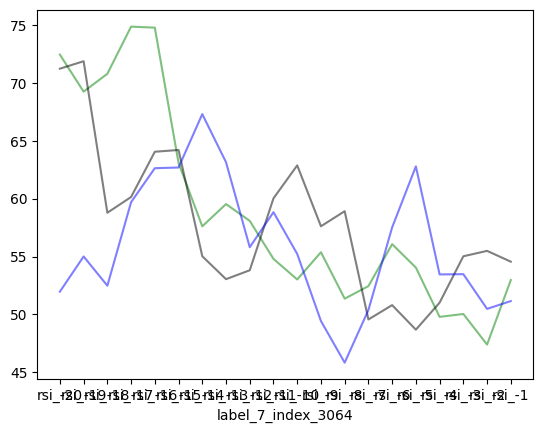

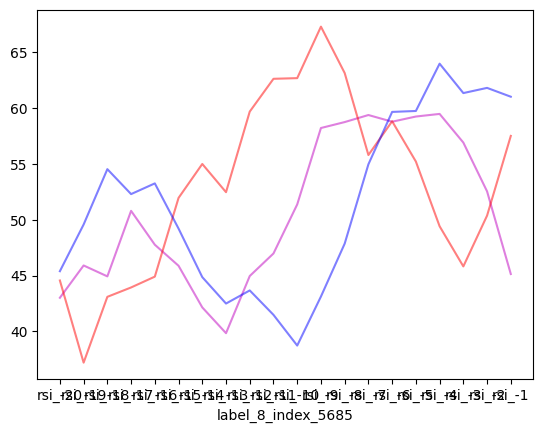

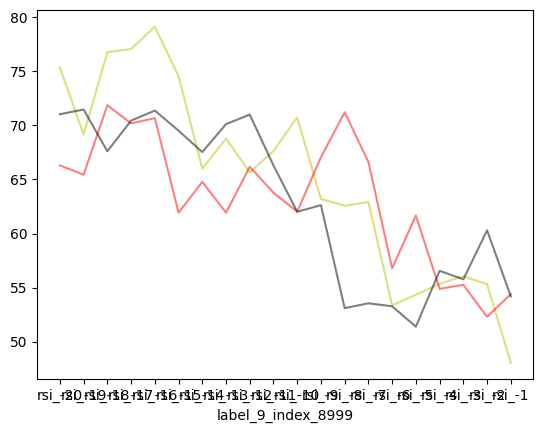

IndexError: Cannot choose from an empty sequence

In [ ]:
""" OHLCV """
for times in range(0,20):
    for i in range(3):
            color = "bgrcmyk"
            index_ = random.choice(df_kmeans[df_kmeans['bar_20_rsi_label']==times].index)
            plt.xlabel(f'label_{times}_index_{index_}')
            plt.plot(df_kmeans.loc[index_,features_kmeans_dict_20bar['rsi']], color=random.choice(color), alpha=0.5)
    plt.show()        

In [ ]:
features = list(df_kmeans.columns[-5:])
features.append('position')
features.extend(bar_1_volome_pct)
df_kmeans[features].shape
df_kmeans[[i for i in features]+['label']].tail(30)


,bar_20_rsi_label,bar_10_adx_label,bar_3_ohlcv_label,bar_1_volome_pct_label,bar_10_rsi_label,position,volume_pct_-1,close_pct_-1,label
497777,6,7,5,0,5,long,0.165006,-0.000843,short
497778,6,7,5,0,5,short,0.097014,-0.000070,short
497779,6,0,5,0,5,short,0.061282,-0.001463,short
497780,6,0,5,0,0,short,0.206680,0.000364,short
497781,3,0,5,5,0,short,-0.562054,0.000085,short
497782,1,0,5,9,0,short,0.680871,0.001000,short
497783,1,0,5,5,0,short,-0.161763,0.000163,short
497784,1,0,5,0,0,short,0.120138,-0.001563,short
497785,1,0,5,5,0,short,-0.142518,0.000946,short
497786,1,0,5,5,0,short,-0.405255,0.000116,short


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.impute import SimpleImputer


In [ ]:
""" process data """
X = df_kmeans[features]
y = df_kmeans['label']
# X_pipeline = make_pipeline(StandardScaler())
# y_pipeline = make_pipeline(StandardScaler())
# X = X_pipeline.fit_transform(X)
# y = y_pipeline.fit_transform(y.values.reshape(-1, 1))
X.replace(np.inf, 0, inplace=True)
num_attribs = list(X.columns)[6:]
cat_attribs = list(X.columns)[:6]
num_pipeline = make_pipeline(
    StandardScaler())
cat_pipeline = make_pipeline(
    OneHotEncoder())
# X_t = cat_pipeline.fit_transform(X[cat_attribs])
preprocessing = ColumnTransformer([
    ('num', num_pipeline ,num_attribs),
    # ('cat', cat_pipeline,make_column_selector(dtype_include=object))
    ('cat2', cat_pipeline,cat_attribs)])
y_pipiline = make_pipeline(OneHotEncoder())
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.9, random_state=42,shuffle=False)

X_t = preprocessing.fit_transform(X_train).toarray()
y_t = y_pipiline.fit_transform(y_train.values.reshape(-1, 1)).toarray()




/tmp/ipykernel_1867/1155581089.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace(np.inf, 0, inplace=True)


In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU, BatchNormalization
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers

In [ ]:
""" classifier """

# model =  Sequential(
#     [
# # Flatten(input_shape=(X_t.shape[1],)),
# Dense(320, activation='relu'),
# Dense(160, activation='relu'),
# Dense(64, activation='relu'),
# Dense(32, activation='relu'),
# Dense(3,activation='softmax')
#     ]
# )
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# ES = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# model.fit(X_t, y_t, epochs=500, batch_size=32, validation_split=0.2, verbose=1, shuffle=False, callbacks=[ES], use_multiprocessing=True, workers=4)

In [ ]:
""" regressor """
model =  Sequential()

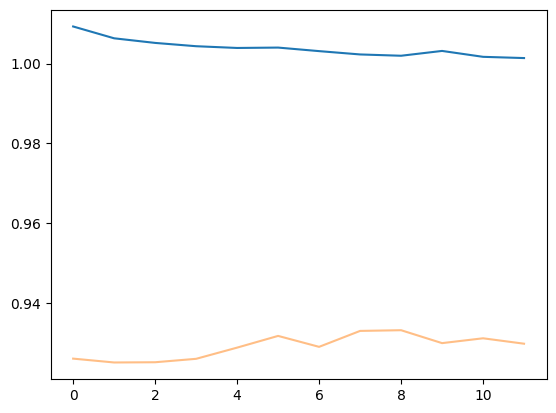

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'], alpha=0.5)
plt.show()